# Playing with neural networks

## Instructions
1. Run all cells in Part 1 Defining Models _understanding the code in this section is not required._

2. One by one, run the cells in Part 2 Fitting Models and try to understand the output of the Linear regression model, Logistic regression model and Neural network model sections

3. Play with the learn_rate, n_iters, n_hidden_units parameters from Part 2 to see how they affect the outcomes above

# Part 1: Defining Models

## Import the libraries we will need

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
%matplotlib inline

### Aside: Theano
Theano is library with helpful functionality for building neural networks, like automatic differentiation. 
**In this course, you will not need to understand any theano.**

We use Theano in some of the functions in this notebook for ease

In [3]:
import theano
from theano import tensor as T

# Define the hard-coded data used for this example

In [4]:
# x values of the data points we will use
x_values = np.arange(-1,1,.05)

# y values of the data points we will use
y_noise = np.asarray([ 0.19200746,  0.26390769,  0.27416557,  0.29274981,  0.34720758,
        0.33646458,  0.3954851 ,  0.38163466,  0.4721299 ,  0.4648484 ,
        0.45125321,  0.49003209,  0.4403167 ,  0.46711053,  0.48810206,
        0.459813  ,  0.46432161,  0.52867192,  0.55053968,  0.50073061,
        0.50371526,  0.50858915,  0.49070523,  0.5121518 ,  0.52849574,
        0.51643671,  0.44317211,  0.51967805,  0.49736733,  0.49924654,
        0.48524065,  0.50282076,  0.56767256,  0.50839501,  0.57744206,
        0.58775349,  0.62222579,  0.57015087,  0.63695049,  0.64991875])

# These are 'true' y values from the underlying distribution with no noise
y_true = np.asarray([ 0.2       ,  0.24053125,  0.27725   ,  0.31034375,  0.34      ,
        0.36640625,  0.38975   ,  0.41021875,  0.428     ,  0.44328125,
        0.45625   ,  0.46709375,  0.476     ,  0.48315625,  0.48875   ,
        0.49296875,  0.496     ,  0.49803125,  0.49925   ,  0.49984375,
        0.5       ,  0.49990625,  0.49975   ,  0.49971875,  0.5       ,
        0.50078125,  0.50225   ,  0.50459375,  0.508     ,  0.51265625,
        0.51875   ,  0.52646875,  0.536     ,  0.54753125,  0.56125   ,
        0.57734375,  0.596     ,  0.61740625,  0.64175   ,  0.66921875])

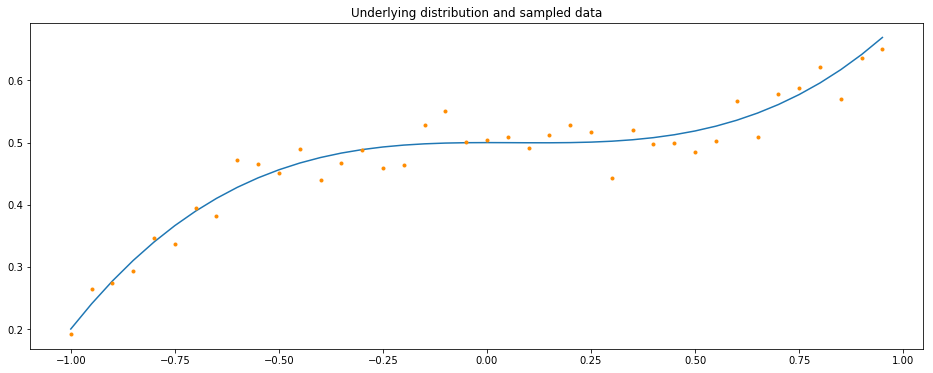

In [5]:
# Visualization of the data used in this notebook
plt.figure(figsize=(16,6))
plt.plot(x_values, y_true)
plt.plot(x_values, y_noise, '.', color='darkorange')
plt.title('Underlying distribution and sampled data')
plt.show()

## Define the 3 different models we will consider
As discussed in the lecture, we define three classes of models: 
1. linear regression, 
2. logistic regression, and 
3. a feed-forward neural network. 

**They are all essentially the same models, but with increasing non-linearity and increasing parameters.**

In [6]:
# model is y_pred = m*x + b
class Linear_Regression:
    
    def __init__(self):
        learning_rate = T.dscalar('learning_rate') 
        x = T.dvector('x')
        y = T.dvector('y')
        
        # Randomly initialize the model parameters 
        # theano.shared() is a technicality 
        self.m = theano.shared(np.random.randn(), name='m')
        self.b = theano.shared(np.random.randn(), name='b')       
        
        # model's prediction, given x and parameters
        y_pred = T.dot(self.m,x)  + self.b
        
        # cost function we will minimize (mean squared error)
        cost = T.sum(T.pow(y_pred - y, 2)) / (2 * x.shape[0])

        # calculate the gradient of the cost function wrt the parameters
        gradient = T.grad(cost, [self.m, self.b])
        
        # define the gradient descent updates to minimize the cost function        
        updates = ([self.m, self.m - learning_rate*gradient[0]],
                   [self.b, self.b - learning_rate*gradient[1]])
        
        # function to take a single gradient step for the minimization
        self.train = theano.function(inputs=[x, y, learning_rate],
                                     outputs=cost,
                                     updates=updates)

        # make a prediction with the model (outputs y_pred)        
        self.predict = theano.function(inputs=[x], 
                                       outputs=y_pred)

In [7]:
# model is y_pred = sigmoid(m*x + b)
class Logistic_Regression:
    
    def __init__(self):
        learning_rate = T.dscalar('learning_rate')
        x = T.dvector('x')
        y = T.dvector('y')
        
        # initialize parameters 
        self.m = theano.shared(np.random.randn(), name = 'm')
        self.b = theano.shared(np.random.randn(), name = 'b')       

        # prediction
        y_pred = T.nnet.sigmoid(T.dot(self.m, x) + self.b)
        
        # cost function 
        cost = T.sum(T.pow(y_pred - y, 2)) / (2 * x.shape[0])

        # gradient of the cost function wrt the parameters
        gradient = T.grad(cost, [self.m, self.b])
        
        # gradient descent updates
        updates = ([self.m, self.m - learning_rate*gradient[0]],
                   [self.b, self.b - learning_rate*gradient[1]])

        # single gradient step 
        self.train = theano.function(inputs=[x, y, learning_rate],
                                     outputs=cost,
                                     updates=updates)
        
        # make a prediction with the model (outputs y_pred)        
        self.predict = theano.function(inputs=[x],
                                       outputs=y_pred)

In [31]:
# model is y_pred = tanh(W2*tanh(W1*x + b1) + b2)
class Feedforward_Network_1D:
    
    def __init__(self, n_hidden_units=100):
        norm = np.sqrt(1. / n_hidden_units)
        learning_rate = T.dscalar('learning_rate')
        x = T.dvector('x')
        y = T.dvector('y')
        
        # Randomly initialize the model parameters
        self.W1 = theano.shared(np.random.randn(n_hidden_units) * norm,
                                name='W1')
        self.b1 = theano.shared(np.random.randn(n_hidden_units, 1) * norm,
                                name='b1', broadcastable=(False, True))
        self.W2 = theano.shared(np.random.randn(n_hidden_units) * norm,
                                name='W2')
        self.b2 = theano.shared(np.random.randn(1) * norm,
                                name='b2')

        # This is the "hidden layer" in the model 
        # it is just a way to breakdown a non-linear function
        h = T.tanh(T.outer(self.W1, x) + self.b1)

        # This is the model's prediction, given x, and the parameters        
        y_pred = T.tanh(T.dot(self.W2, h) + self.b2.dimshuffle(0, 'x'))
        
        # This is cost function we will minimize (mean squared error of the model)
        cost = T.sum(T.pow(y_pred - y, 2)) / (2 * x.shape[0])
        
        # Here we calculate the gradient of the cost function wrt the parameters        
        gradient = T.grad(cost, [self.W1, self.b1, self.W2, self.b2])
        
        # Here we define the gradient descent updates to minimize the cost function        
        updates = ([self.W1, self.W1 - learning_rate*gradient[0]],
                   [self.b1, self.b1 - learning_rate*gradient[1]], 
                   [self.W2, self.W2 - learning_rate*gradient[2]],
                   [self.b2, self.b2 - learning_rate*gradient[3]])

        # This function takes a single gradient step for the minimization        
        self.train = theano.function(inputs=[x, y, learning_rate],
                                     outputs=cost,
                                     updates=updates)
        
        # This function makes a prediction with the model (outputs y_pred)      
        self.predict = theano.function(inputs=[x],
                                       outputs=y_pred)

## Define minimization algorithm 

In [9]:
# This is the minimization function for all models
def learn(model, n_iters=100000, learn_rate=0.1):
    '''Learn a model to minimise the model's cost function.'''
    
    # track some metrics
    print_freq = int(n_iters/10.)
    cost  = 0.0
    costs = []
    iters= []
    start = time.time()

    for i in range(n_iters):
        cost += model.train(x_values, y_noise, learn_rate)
        
        if (i % print_freq == 0 and i > 0) or i == n_iters-1:  # print metrics
            print("At iteration %d, cost equals: %.6f, Total run time = %.2f mins" 
                  % (i, cost/print_freq, (time.time()-start)/60.))
            costs.append(cost/print_freq)
            iters.append(i)
            cost = 0
    
    return iters, costs

## Define functions to visualise learning and performanace

In [10]:
def plot_cost(iters, costs):
    '''Plot the cost over iterations.'''
    plt.figure(figsize=(14,4))
    plt.plot(iters, costs)
    plt.title('Cost function vs learning-iteration step')
    plt.show()

In [11]:
def plot_prediction(model):
    '''Plot predictions versus data.'''
    predict_array = np.ndarray(len(x_values))
    predict_array = model.predict(x_values).reshape(len(x_values),)

    plt.figure(figsize=(14,4))
    plt.plot(x_values, predict_array,  color='darkblue', label='Model prediction')
    plt.plot(x_values, y_true, '-', color='darkgreen', label='Underlying distribution')
    plt.plot(x_values, y_noise,'.', color='darkorange', label='Training data')
    plt.title('Model prediction compared to true underlying distribution')
    plt.legend()
    plt.show()

-----

# Part 2: Fitting Models

## Fit Linear regression model

In [12]:
# Define the linear-regression model
linear_regression_model = Linear_Regression()

# Learn the models parameters
linear_regression_iters, linear_regression_costs = learn(linear_regression_model, 
                                                         n_iters=1000, 
                                                         learn_rate=0.01)

At iteration 100, cost equals: 0.318969, Total run time = 0.00 mins
At iteration 200, cost equals: 0.043928, Total run time = 0.00 mins
At iteration 300, cost equals: 0.007561, Total run time = 0.00 mins
At iteration 400, cost equals: 0.002410, Total run time = 0.00 mins
At iteration 500, cost equals: 0.001574, Total run time = 0.00 mins
At iteration 600, cost equals: 0.001387, Total run time = 0.00 mins
At iteration 700, cost equals: 0.001323, Total run time = 0.00 mins
At iteration 800, cost equals: 0.001294, Total run time = 0.00 mins
At iteration 900, cost equals: 0.001280, Total run time = 0.00 mins
At iteration 999, cost equals: 0.001261, Total run time = 0.00 mins


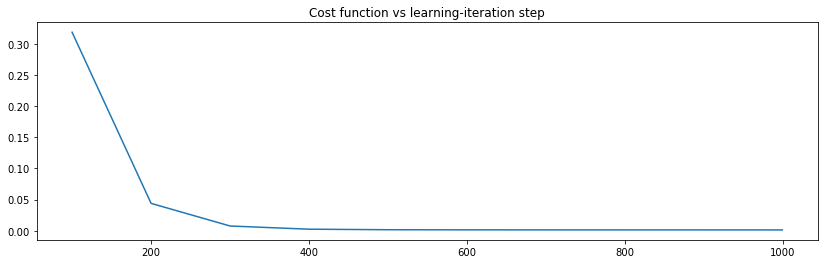

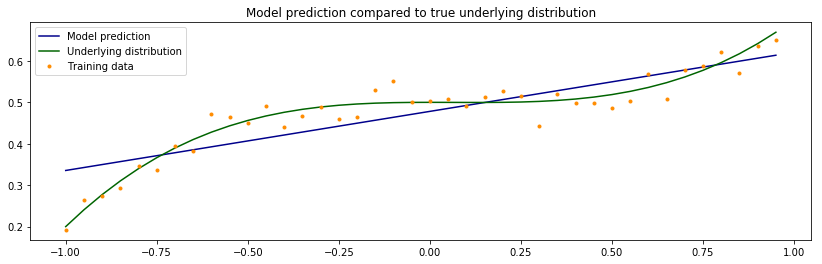

In [13]:
# Plot the results of the learned linear-regression model
plot_cost(linear_regression_iters, linear_regression_costs)
plot_prediction(linear_regression_model)

## Fit Logistic regression model

In [14]:
# Define the logistic-regression model
logistic_regression_model = Logistic_Regression()

# Learn the models parameters
logistic_regression_iters, logistic_regression_costs = learn(logistic_regression_model, 
                                                             n_iters=20000, 
                                                             learn_rate=0.01)

At iteration 2000, cost equals: 0.036818, Total run time = 0.00 mins
At iteration 4000, cost equals: 0.016451, Total run time = 0.00 mins
At iteration 6000, cost equals: 0.007261, Total run time = 0.00 mins
At iteration 8000, cost equals: 0.003790, Total run time = 0.01 mins
At iteration 10000, cost equals: 0.002379, Total run time = 0.01 mins
At iteration 12000, cost equals: 0.001779, Total run time = 0.01 mins
At iteration 14000, cost equals: 0.001517, Total run time = 0.01 mins
At iteration 16000, cost equals: 0.001401, Total run time = 0.01 mins
At iteration 18000, cost equals: 0.001349, Total run time = 0.01 mins
At iteration 19999, cost equals: 0.001325, Total run time = 0.01 mins


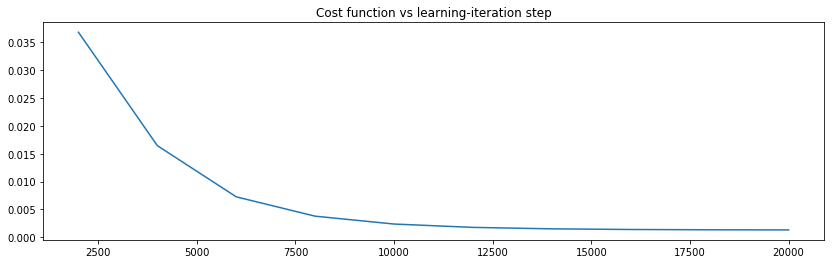

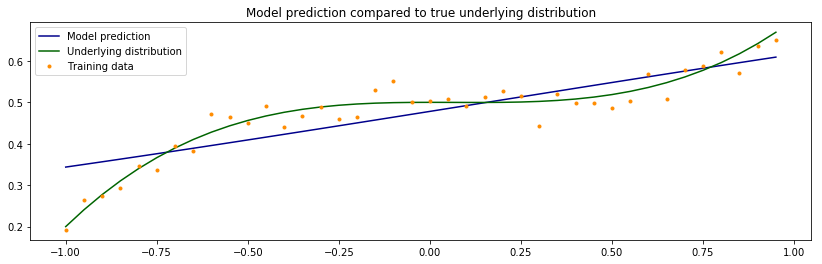

In [15]:
# Plot the results of the learned logistic-regression model
plot_cost(logistic_regression_iters, logistic_regression_costs)
plot_prediction(logistic_regression_model)

## Fit Neural network model

In [48]:
# Define the feed-forward neural network model
feedforward_network_1d_model = Feedforward_Network_1D(n_hidden_units=300)

# Learn the models parameters
feedforward_network_1d_iters, feedforward_network_1d_costs = learn(feedforward_network_1d_model, 
                                                                   n_iters=10000, 
                                                                   learn_rate=0.9)

At iteration 1000, cost equals: 0.001368, Total run time = 0.01 mins
At iteration 2000, cost equals: 0.001177, Total run time = 0.01 mins
At iteration 3000, cost equals: 0.001174, Total run time = 0.02 mins
At iteration 4000, cost equals: 0.001170, Total run time = 0.03 mins
At iteration 5000, cost equals: 0.001164, Total run time = 0.03 mins
At iteration 6000, cost equals: 0.001154, Total run time = 0.04 mins
At iteration 7000, cost equals: 0.001132, Total run time = 0.05 mins
At iteration 8000, cost equals: 0.001075, Total run time = 0.05 mins
At iteration 9000, cost equals: 0.000961, Total run time = 0.06 mins
At iteration 9999, cost equals: 0.000820, Total run time = 0.07 mins


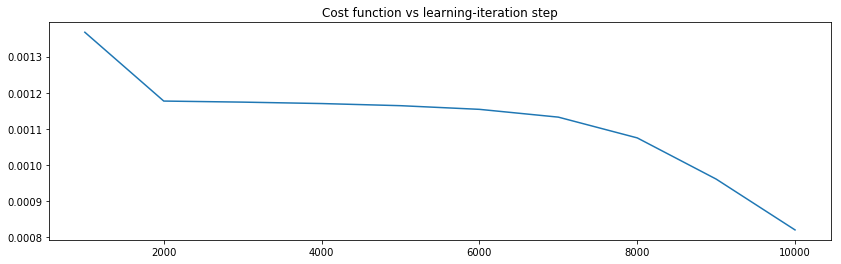

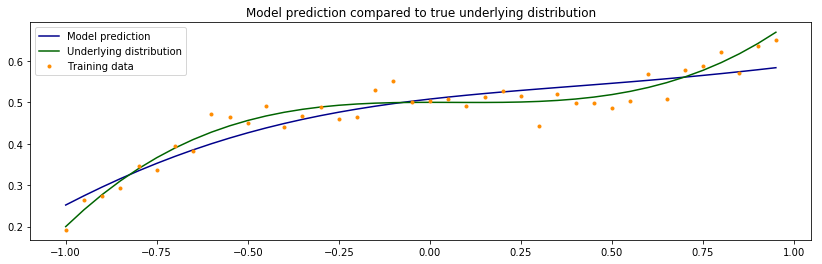

In [49]:
# Plot the results of the learned feed-forward neural network model
plot_cost(feedforward_network_1d_iters, feedforward_network_1d_costs)
plot_prediction(feedforward_network_1d_model)

#### Play with the learn_rate, n_iters and n_hidden_units parameters from Part 2 to see how they affect the outcomes above